## Imports and Data Loading

> P.S. We used kaggle to run the code, so there are few kaggle specific imports too


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/democratvsrepublicantweets/ExtractedTweets.csv
/kaggle/input/democratvsrepublicantweets/TwitterHandles.csv


In [ ]:
import re
import nltk
import gensim
import pyLDAvis.gensim
from nltk.corpus import stopwords
from gensim import corpora
from gensim.models import LdaModel
import string
import random

from datetime import datetime, timedelta

In [2]:
df = pd.read_csv("/kaggle/input/democratvsrepublicantweets/ExtractedTweets.csv")

In [3]:
df.Party.value_counts()

Party
Republican    44392
Democrat      42068
Name: count, dtype: int64

## Preprocessing

- Sampling data from 80k rows to 20k rows [we have less time and compute :(, but yeah its a stratified sampling, so we should have a fairly good representation of the data]
- Preprocess the twitter text data to remove special characters, numbers, extra spaces, urls, emojis, etc.
- Generate random timestamps for the data as there was no original timestamp provided (This is done to simulate the real-world scenario)


In [ ]:
## this is too much, lets sample

from sklearn.model_selection import train_test_split

# Desired sample size
sample_size = 20_000

df_sampled, _ = train_test_split(
    df, train_size=sample_size, stratify=df["Party"], random_state=42
)

# Display the value counts to verify stratification
print(df_sampled["Party"].value_counts())

Party
Republican    10269
Democrat       9731
Name: count, dtype: int64


In [ ]:
# Download stopwords if not already downloaded
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))


def preprocess_tweet(tweet):
    # Convert to lowercase
    tweet = tweet.lower()

    # Remove URLs
    tweet = re.sub(r"http\S+|www\S+|https\S+", "", tweet)

    # Remove mentions and hashtags
    tweet = re.sub(r"@\w+|#\w+", "", tweet)

    tweet = re.sub("rt ", "", tweet)

    # Remove punctuations
    tweet = tweet.translate(str.maketrans("", "", string.punctuation))

    # Remove numbers
    tweet = re.sub(r"\d+", "", tweet)

    # Remove stopwords
    tweet = " ".join([word for word in tweet.split() if word not in stop_words])

    # Remove extra whitespaces
    tweet = re.sub(r"\s+", " ", tweet).strip()

    return tweet


# Generate random timestamps within the range for each row
def random_date(start, end):
    delta = end - start
    random_days = random.randint(0, delta.days)
    random_seconds = random.randint(0, 24 * 60 * 60 - 1)
    return start + timedelta(days=random_days, seconds=random_seconds)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
df_sampled["Processed Tweet"] = df_sampled["Tweet"].apply(preprocess_tweet)

In [ ]:
start_date = datetime(2015, 1, 1)
end_date = datetime(2018, 12, 31)

df_sampled["timestamp"] = [
    random_date(start_date, end_date) for _ in range(len(df_sampled))
]

df_sampled = df_sampled.sort_values(by="timestamp").reset_index(drop=True)

In [8]:
df_sampled.head()

,Party,Handle,Tweet,Processed Tweet,timestamp
0,Democrat,repsandylevin,The notion that this bill for the middle class...,notion bill middle class untrue fib,2015-01-01 00:10:09
1,Republican,RepJoeWilson,"At the @HASCRepublicans hearing today, I quest...",hearing today questioned expewitnesses army se...,2015-01-01 01:05:22
2,Democrat,LloydDoggettTX,"RT @texasdemocrats: Two years ago, marriage eq...",two years ago marriage equality became law lan...,2015-01-01 01:59:39
3,Democrat,NancyPelosi,With at least seven independent federal invest...,least seven independent federal investigations...,2015-01-01 03:07:45
4,Democrat,jahimes,RT @FairfieldCares: National Prescription Drug...,national prescription drug takeback day saturd...,2015-01-01 06:42:27


## LDAModel


### Find out the topics


In [ ]:
tokenized_tweets = [tweet.split() for tweet in df_sampled["Processed Tweet"]]

dictionary = corpora.Dictionary(tokenized_tweets)
corpus = [dictionary.doc2bow(tweet) for tweet in tokenized_tweets]

num_topics = 5
lda_model = LdaModel(
    corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, passes=10
)

# Display topics
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx + 1}: {topic}")

# Optional: Visualize topics with pyLDAvis (in Jupyter Notebook or HTML output)
pyLDAvis.enable_notebook()  # Uncomment for Jupyter Notebook
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(vis, "lda_visualization.html")

Topic 1: 0.014*"great" + 0.013*"amp" + 0.009*"thanks" + 0.007*"today" + 0.006*"time" + 0.006*"us" + 0.006*"small" + 0.006*"forward" + 0.005*"students" + 0.005*"thank"
Topic 2: 0.016*"amp" + 0.010*"women" + 0.008*"americans" + 0.008*"families" + 0.008*"country" + 0.008*"people" + 0.008*"every" + 0.007*"american" + 0.007*"must" + 0.007*"day"
Topic 3: 0.016*"today" + 0.011*"thank" + 0.008*"honor" + 0.008*"great" + 0.008*"us" + 0.007*"hearing" + 0.007*"th" + 0.007*"day" + 0.006*"live" + 0.006*"join"
Topic 4: 0.019*"tax" + 0.006*"cuts" + 0.006*"jobs" + 0.006*"amp" + 0.006*"trump" + 0.006*"new" + 0.005*"pay" + 0.005*"happy" + 0.005*"states" + 0.004*"president"
Topic 5: 0.016*"house" + 0.012*"bill" + 0.010*"act" + 0.009*"amp" + 0.009*"today" + 0.008*"congress" + 0.006*"proud" + 0.006*"vote" + 0.006*"legislation" + 0.006*"health"


In [ ]:
# visualizing the topics
def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
    return vis


plot_lda_vis(lda_model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.010709  0.214302       1        1  24.286556
2     -0.212851 -0.057103       2        1  22.124667
0     -0.096432 -0.054952       3        1  19.175985
1      0.166748 -0.179534       4        1  17.691628
3      0.131827  0.077287       5        1  16.721165, topic_info=       Term        Freq        Total Category  logprob  loglift
77      tax  737.000000   737.000000  Default  30.0000  30.0000
211   house  779.000000   779.000000  Default  29.0000  29.0000
100   great  961.000000   961.000000  Default  28.0000  28.0000
0      bill  636.000000   636.000000  Default  27.0000  27.0000
256   women  359.000000   359.000000  Default  26.0000  26.0000
...     ...         ...          ...      ...      ...      ...
184     get   88.537332   279.016294   Topic5  -5.9047   0.6406
15    today  102.745243  1553.115650   Topic5  -5.7559  -0.9273
1018    one   90.072933   426.086991   Topic5  -5.8875   0.2345
100   great   94.015885   961.088547   Topic5  -5.8447  -0.5361
0      bill   90.444799   636.775986   Topic5  -5.8834  -0.1632

[330 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
2519      3  0.983602  accountable
384       3  0.183289       across
384       4  0.814620       across
547       1  0.809026          act
547       5  0.190359          act
...     ...       ...          ...
773       1  0.239324            …
773       2  0.359703            …
773       3  0.124678            …
773       4  0.124678            …
773       5  0.151906            …

[514 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 1, 2, 4])

### Assign each tweet to a specific topic


In [ ]:
# Define the threshold
threshold = 0.3


# Function to assign topics based on threshold
def assign_topic(lda_model, dictionary, tweet, threshold=0.3):
    bow = dictionary.doc2bow(tweet)
    topics = lda_model.get_document_topics(bow)
    for topic_id, prob in topics:
        if prob >= threshold:
            return topic_id + 1  # Adding 1 for a 1-based index
    return None  # No topic meets the threshold


df_sampled["Assigned Topic"] = [
    assign_topic(lda_model, dictionary, tweet, threshold) for tweet in tokenized_tweets
]

In [12]:
df_sampled[df_sampled["Assigned Topic"].isna()]

,Party,Handle,Tweet,Processed Tweet,timestamp,Assigned Topic
153,Democrat,janschakowsky,https://t.co/V5CiGJo49U,,2015-01-11 09:42:22,NaN
184,Republican,WarrenDavidson,#DeedsNotWords #progress https://t.co/N5Y5qVFL96,,2015-01-13 11:57:56,NaN
227,Democrat,RepValDemings,After serving on the Hostage Negotiations Team...,serving hostage negotiations team yrs orlando ...,2015-01-16 17:43:49,NaN
250,Republican,JudgeCarter,#GoArmy! https://t.co/m5Z0GysMex,,2015-01-18 00:12:38,NaN
406,Republican,RepJoeWilson,.@JenMiller0412 #AskJoeWilson https://t.co/T7e...,,2015-01-29 12:59:02,NaN
...,...,...,...,...,...,...
19880,Republican,RepMikeCoffman,https://t.co/9Ue6DozKej,,2018-12-23 09:23:28,NaN
19902,Democrat,RepZoeLofgren,"RT @JECDems: Rescinding #DACA would remove 30,...",rescinding would remove jobs month economy new...,2018-12-24 14:04:15,NaN
19917,Republican,RepDLamborn,Particularly excited to see Sam Brownback's co...,particularly excited see sam brownbacks confir...,2018-12-25 11:24:35,NaN
19931,Republican,RepBrianMast,I'm committed to getting the SB10 reservoir au...,im committed getting sb reservoir authorized c...,2018-12-26 15:52:28,NaN


## Sentiment Analysis

- Used the sentiment analysis model to predict the sentiment of each tweet thus inturn predicting the sentiment of each topic


In [ ]:
from transformers import pipeline

sentiment_pipeline = pipeline("sentiment-analysis", device=0)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
from tqdm.auto import tqdm

tqdm.pandas()

df_sampled[["Sentiment"]] = df_sampled["Processed Tweet"].apply(
    lambda x: pd.Series(
        {
            "Sentiment": sentiment_pipeline(x)[0]["label"],
        }
    )
)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


<Axes: xlabel='Party,Sentiment'>

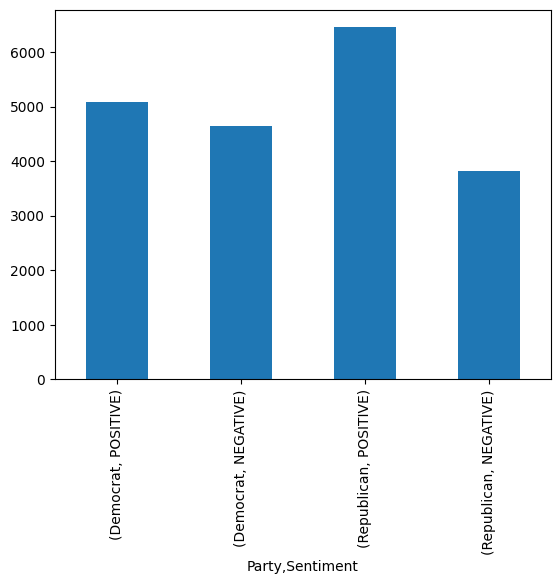

In [25]:
df_sampled.groupby("Party")["Sentiment"].value_counts().plot(kind="bar")

In [22]:
df_sampled

,Party,Handle,Tweet,Processed Tweet,timestamp,Assigned Topic,Sentiment
0,Democrat,repsandylevin,The notion that this bill for the middle class...,notion bill middle class untrue fib,2015-01-01 00:10:09,4.0,NEGATIVE
1,Republican,RepJoeWilson,"At the @HASCRepublicans hearing today, I quest...",hearing today questioned expewitnesses army se...,2015-01-01 01:05:22,3.0,NEGATIVE
2,Democrat,LloydDoggettTX,"RT @texasdemocrats: Two years ago, marriage eq...",two years ago marriage equality became law lan...,2015-01-01 01:59:39,4.0,NEGATIVE
3,Democrat,NancyPelosi,With at least seven independent federal invest...,least seven independent federal investigations...,2015-01-01 03:07:45,4.0,NEGATIVE
4,Democrat,jahimes,RT @FairfieldCares: National Prescription Drug...,national prescription drug takeback day saturd...,2015-01-01 06:42:27,3.0,NEGATIVE
...,...,...,...,...,...,...,...
19995,Democrat,RepBarragan,The #IRS is extending the tax-filing deadline ...,extending taxfiling deadline extra day due com...,2018-12-31 14:42:31,2.0,NEGATIVE
19996,Republican,CongCulberson,RT @RepKevinBrady: Next #TaxDay you will see l...,next see lower rates tax code that’s great,2018-12-31 16:58:20,4.0,POSITIVE
19997,Republican,RepKevinBrady,TRUTH CHECK: @AP ignores the over 30 MILLION h...,truth check ignores million hardworking americ...,2018-12-31 21:05:12,2.0,NEGATIVE
19998,Democrat,chakafattah,@YahooNews https://t.co/tomyhshNMM,,2018-12-31 21:20:31,NaN,POSITIVE


## Save the outputs

- Processed csv file
- LDA Model


In [ ]:
df_sampled.to_csv("final.csv")

In [26]:
lda_model

In [27]:
lda_model.save("lda_model.gensim")